In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def create_grid_2d(res, size_x, size_y, x_offset):
   grid = (np.zeros((res, res)), np.zeros((res, res)))
   for i in range(len(grid[0][:, 0])):
      for j in range(len(grid[1][i, :])):
         grid[0][i, j] = float(i)/float(res-1)*size_x + x_offset
         grid[1][i, j] = float(j)/float(res-1)*size_y
   return grid

def create_grid(res, size_x, x_offset):
   grid = (np.zeros((res, 1)), np.zeros((res, 1)))
   for i in range(len(grid[0][:, 0])):
      for j in range(len(grid[1][i, :])):
         grid[0][i, j] = float(i)/float(res-1)*size_x + x_offset
         grid[1][i, j] = 0.
   return grid


In [40]:

def distance(x, y, xc, yc):
   return np.sqrt((x - xc)**2 + (y - yc)**2)

def circular_refinement(x, y, xc, yc, dist_min, dist_max, mesh_size_in, mesh_size_out, global_mesh_size):
   dist = distance(x, y, xc, yc)
   if dist < dist_max:
      factor = ((distance(x, y, xc, yc) - dist_min)/(dist_max - dist_min))**2
      return factor*(mesh_size_out - mesh_size_in) + mesh_size_in
   else:
      return global_mesh_size

def rect_refinement(x, y, xc, yc, length, height, mesh_size_in, mesh_size_out, thickness):
   if (abs(x - xc) <= length/2) and (abs(y - yc) < height/2):
      return mesh_size_in
   elif (abs(x - xc) <= length/2 + thickness) and (abs(y - yc) < height/2 + thickness):
      l_x = abs(x - xc - length/2)
      l_y = abs(y - yc - height/2)
      factor = min(l_x, l_y)/thickness
      return factor*(mesh_size_out - mesh_size_in) + mesh_size_in
   else:
      return mesh_size_out

def threshold(x, y, xc, yc, dist_threshold, mesh_size_in, mesh_size_out):
   dist = distance(x, y, xc, yc)
   if dist < dist_threshold:
      return mesh_size_in
   else:
      return mesh_size_out
   

In [44]:
# Cylinder
diameter = 0.01
n_points_cyl = 50

# bounding box
height = 52*diameter
length_upstream = 10*diameter
length_downstream = 46*diameter
global_mesh_size = diameter*2

# refinement zone around the cylinder
length_refinement = diameter
length_refinement_downstream = 4*diameter
refined_mesh_size = 2*diameter/n_points_cyl

centers = [(0, 0)]

In [15]:
def mesh(grid):
   mesh = np.zeros((len(grid[0][:, 0]), len(grid[1][0, :])))
   total_length = length_refinement + length_refinement_downstream
   delta = diameter/n_points_cyl
   for i in range(len(grid[0][:, 0])):
      for j in range(len(grid[1][i, :])):
         x = grid[0][i, j]
         y = grid[1][i, j]
         for pos in centers:
            xc = total_length/2 - length_refinement + pos[0]
            yc = pos[1]
            const_dist = diameter/2.*1.1
            dist_total = diameter/2.*2.
            size = threshold(x, y, pos[0], pos[1], diameter/2., delta, global_mesh_size)
            size = min(size, rect_refinement(x, y, xc, yc, total_length, length_refinement*2, refined_mesh_size, global_mesh_size, 40*diameter))
            size = min(size, circular_refinement(x, y, pos[0], pos[1], diameter/2., const_dist, delta*1.02, delta*1.05, global_mesh_size))
            size = min(size, circular_refinement(x, y, pos[0], pos[1], const_dist, dist_total, delta*1.05, refined_mesh_size, global_mesh_size))
            mesh[i, j] = size
   return mesh

# Finite difference scheme
def grad_1d(grid, size):
   grad = np.zeros(len(grid[0][:, 0]))
   for i in range(1, len(grid[0][:, 0])-1):
      grad[i+1] = (size[i+1, 0] - size[i-1, 0])/(grid[0][i+1, 0] - grid[0][i-1, 0])
   grad[0] = (size[1, 0] - size[0, 0])/(grid[0][1, 0] - grid[0][0, 0])
   grad[-1] = (size[-1, 0] - size[-2, 0])/(grid[0][-1, 0] - grid[0][-2, 0])
   return grad



/tmp/ipykernel_321347/2461874805.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


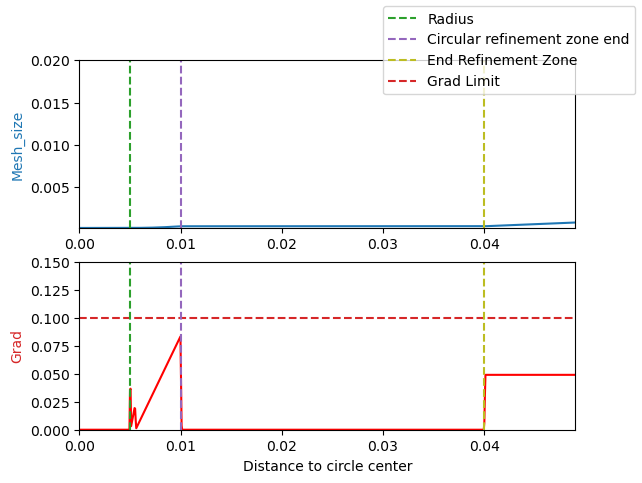

In [ ]:
def plot_2d(res: int):
   grid = create_grid_2d(res, length_upstream + length_downstream, height/2, -length_upstream)
   size = mesh(grid)
   plt.pcolormesh(grid[0], grid[1], size)
   plt.colorbar()
   plt.savefig("2d.png", dpi = 300)
   plt.show()

def plot(res: int):
   grid = create_grid(res, length_upstream + length_downstream, -length_upstream)
   size = mesh(grid)
   plt.plot(grid[0][:, 0], size[:, 0])
   plt.axline((diameter/2., 0.), (diameter/2., 1.), label='Radius', ls='--', color='tab:blue')
   plt.axline((diameter, 0.), (diameter, 1.), label='Circular refinement zone', ls='--', color='tab:red')
   plt.axline((4*diameter, 0.), (4*diameter, 1.), label='End Refinement Zone', ls='--', color='tab:green')
   plt.xlim([0., 0.05])
   delta = diameter/n_points_cyl
   plt.ylim([delta*0.90, global_mesh_size])
   plt.legend()
   plt.savefig("1d.png", dpi = 300)
   plt.show()

def plot_grad(res: int):
   grid = create_grid(res, length_upstream + length_downstream, -length_upstream)
   size = mesh(grid)
   plt.plot(grid[0][:, 0], grad_1d(grid, size))
   plt.axline((diameter/2., 0.), (diameter/2., 1.), label='Radius', ls='--', color='tab:blue')
   plt.axline((diameter, 0.), (diameter, 1.), label='Circular refinement zone', ls='--', color='tab:red')
   
   plt.xlim([0., 0.05])
   plt.ylim([-0.3, 0.3])
   plt.savefig("1d_grad.png", dpi = 300)
   plt.show()

def plot_1d(res):
   fig, axs = plt.subplots(2, 1)
   ax = axs[0]
   ax2 = axs[1]
   grid = create_grid(res, length_upstream + length_downstream, -length_upstream)
   size = mesh(grid)
   ax.plot(grid[0][:, 0], size[:, 0], color='tab:blue')
   ax.set_ylabel("Mesh_size", color='tab:blue')
   ax.axline((diameter/2., 0.), (diameter/2., 1.), label='Radius', ls='--', color='tab:green')
   ax.axline((diameter, 0.), (diameter, 1.), label='Circular refinement zone end', ls='--', color='tab:purple')
   ax.axline((4*diameter, 0.), (4*diameter, 1.), label='End Refinement Zone', ls='--', color='tab:olive')
   ax.axline((0., delta), (1., delta), label=r'$\Delta$', ls='--', color='tab:blue')
   delta = diameter/n_points_cyl
   ax.set_ylim([delta*0.90, global_mesh_size])
   ax.set_xlim([0., 0.049])

   ax2.set_xlim([0., 0.049])
   ax2.plot(grid[0][:, 0], abs(grad_1d(grid, size)), color='red')
   ax2.set_ylim([0., 0.15])
   ax2.set_ylabel("Grad", color='tab:red')
   ax2.axline((0., 0.1), (1., 0.1), label='Grad Limit', ls='--', color='tab:red')
   ax2.axline((diameter/2., 0.), (diameter/2., 1.), ls='--', color='tab:green')
   ax2.axline((diameter, 0.), (diameter, 1.), ls='--', color='tab:purple')
   ax2.axline((4*diameter, 0.), (4*diameter, 1.), ls='--', color='tab:olive')
   ax2.set_xlabel('Distance to circle center')
   
   fig.legend()
   fig.savefig("1d.png", dpi = 300)
   fig.show()

# plot(1000)
# plot_grad(10000)
plot_1d(10000)
# plot_2d(1000)